# Introduction

Fourier series transforms are a powerful way to model time series data sets that exhibit seasonality. We can do specific analysis to determine how many pairs of curves to use.

# Preview the data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
 
df = pd.read_csv('airline-passengers.csv', parse_dates=["Date"])
df.head()

,Date,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


# Plotting a time series

We use this article as a starting point https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/ and this article for additional data analysis ideas https://www.kaggle.com/code/ryanholbrook/seasonality 

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

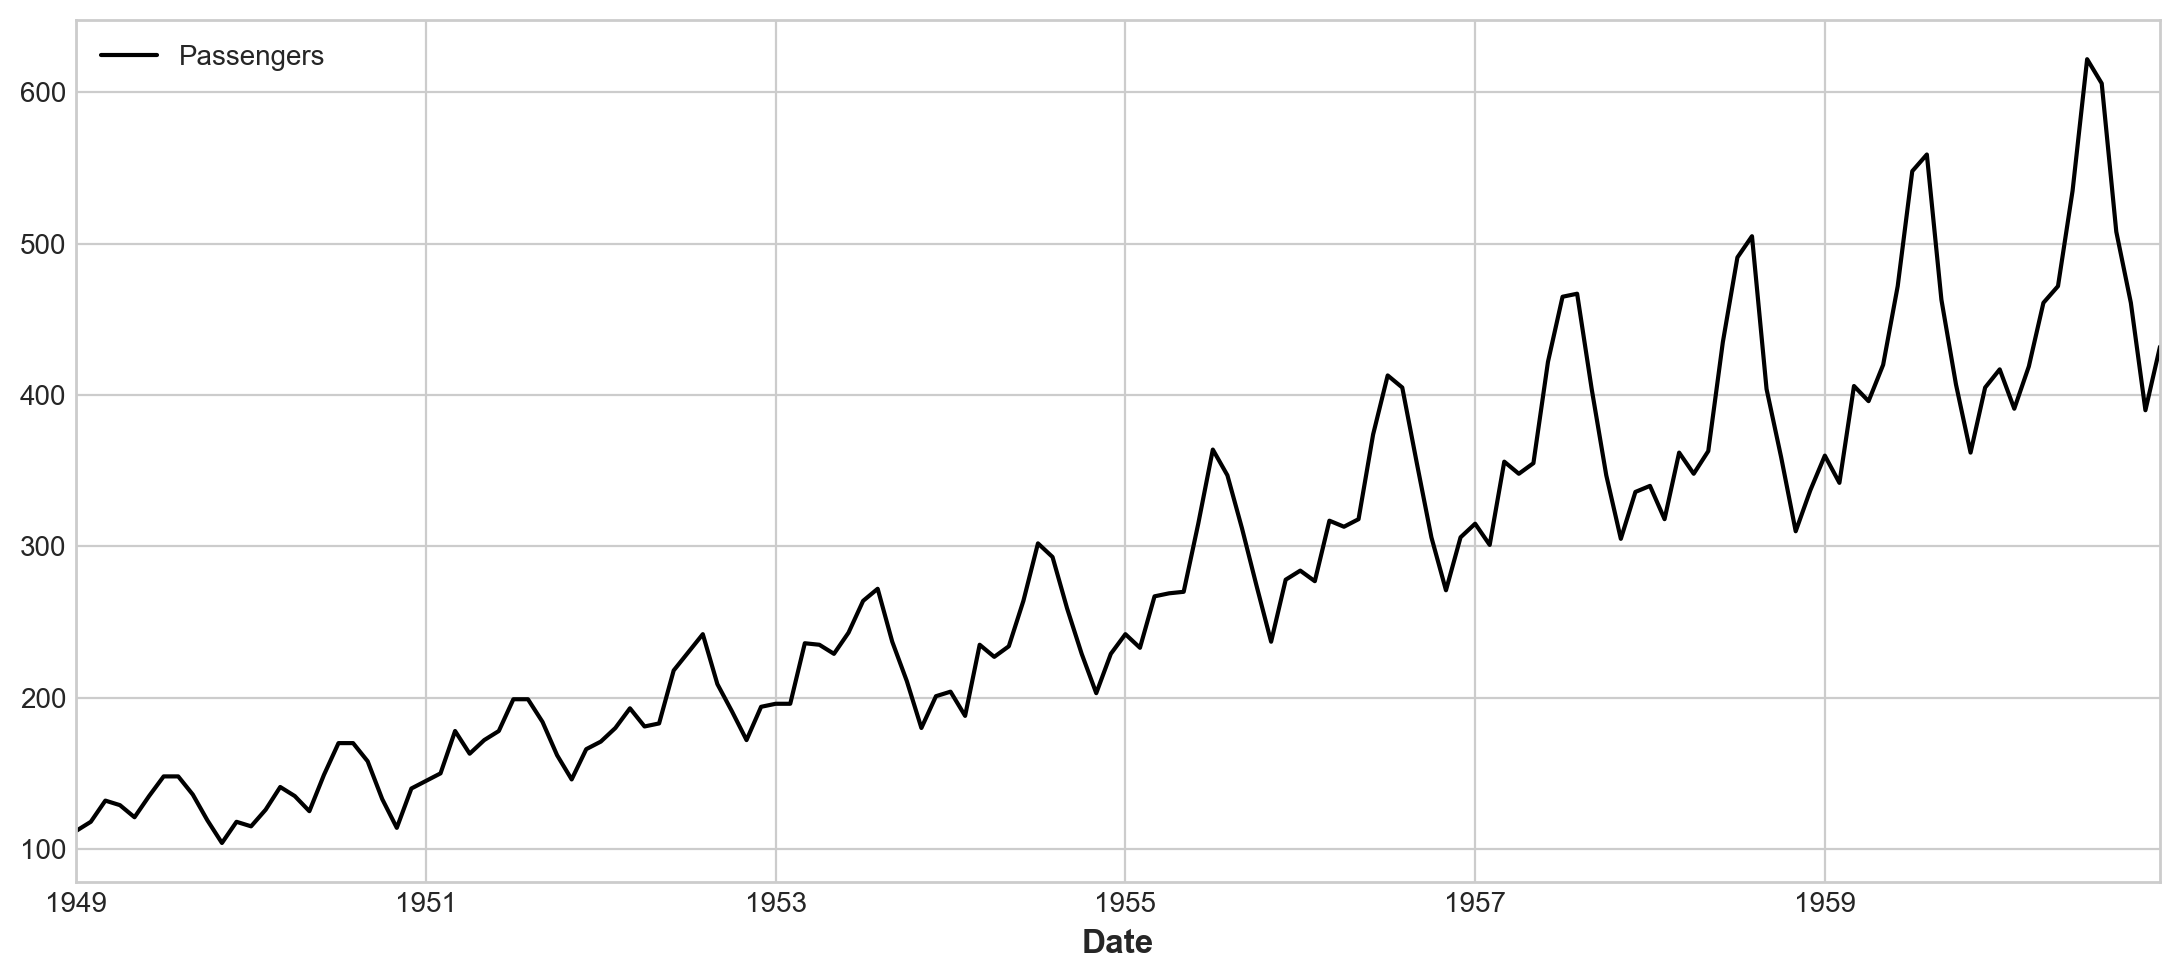

In [3]:
df[["Passengers"]] = df[["Passengers"]].values.astype('float32')
df = df.set_index("Date").to_period("M")

df.plot(color="black")
plt.show()

# Viewing seasonality

We can see that the graph seems to repeat a similar shape every 12 months. This makes sense for anyone who has traveled in different parts of the year in the US.

In [4]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

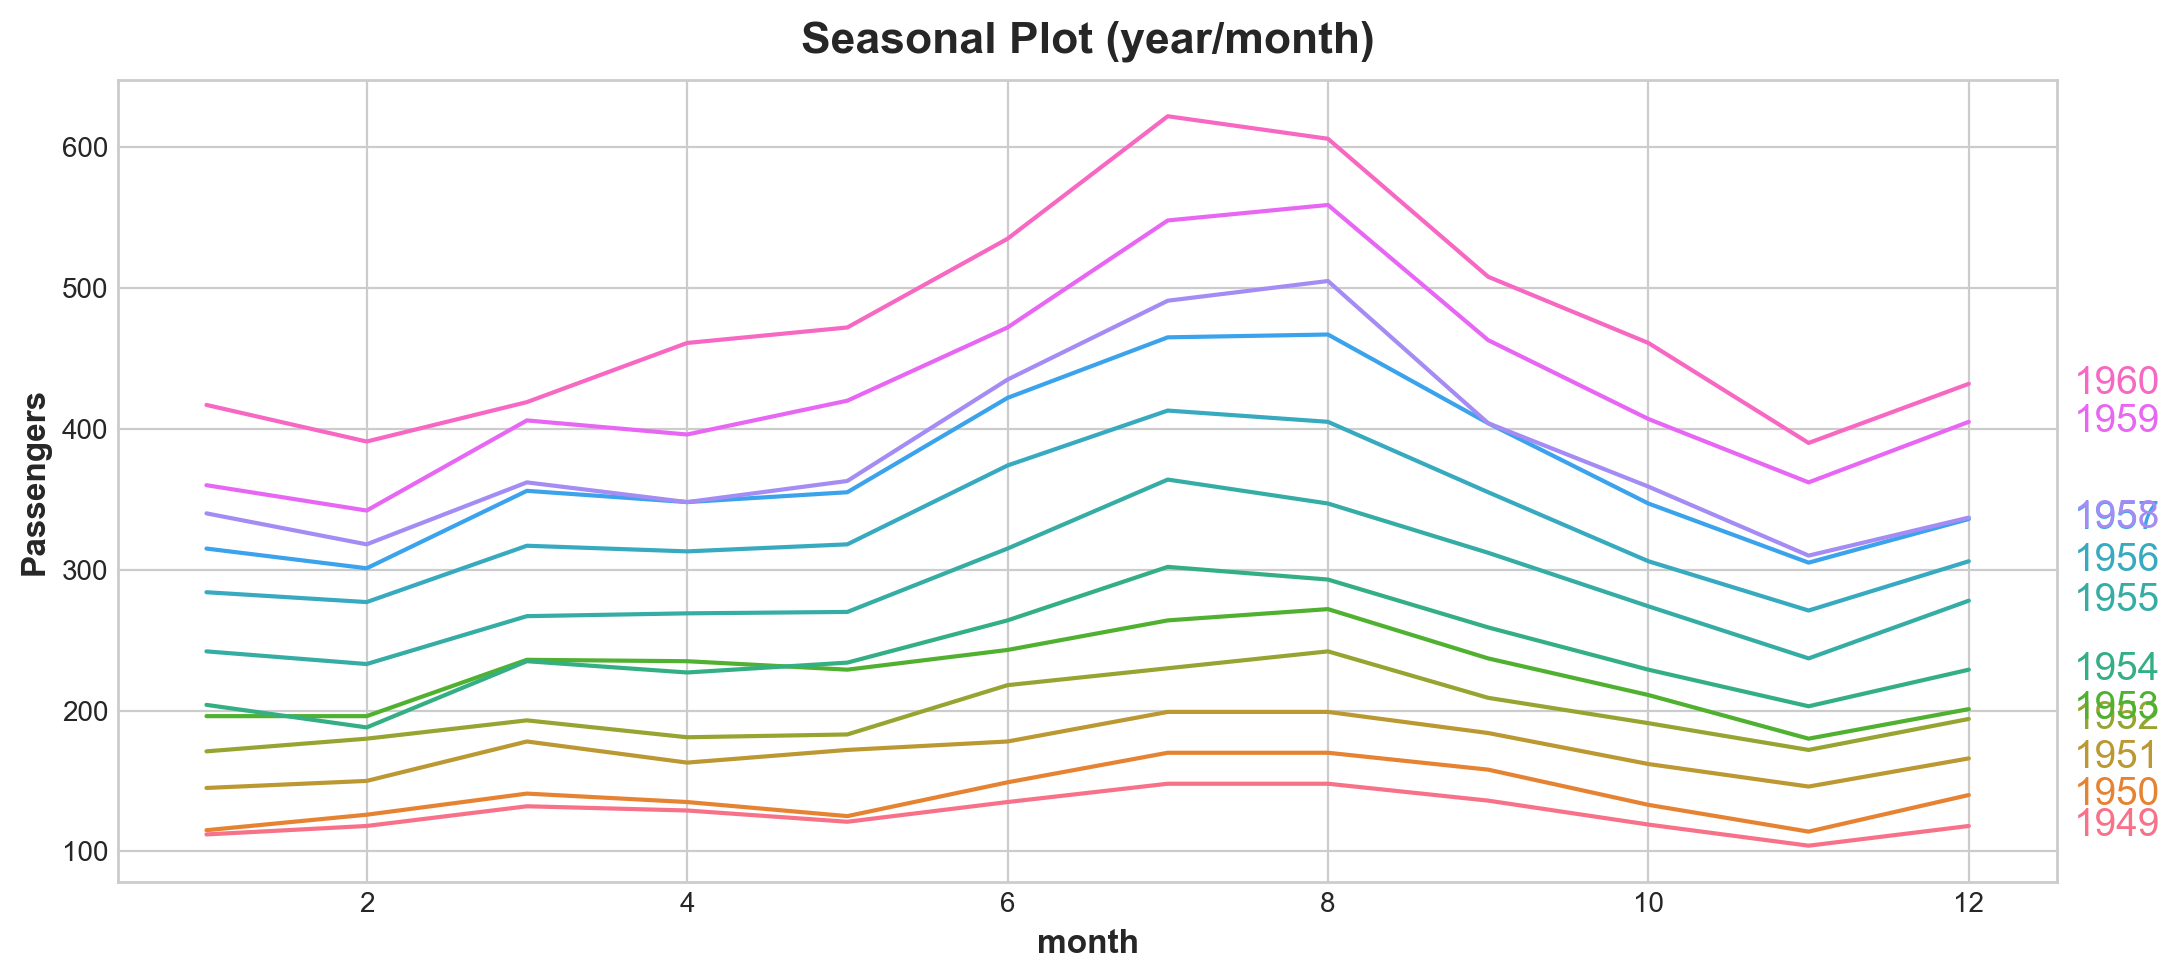

In [5]:
X = df.copy()
X["month"] = X.index.month  # the seasonal period
X["year"] = X.index.year

seasonal_plot(X, y="Passengers", period="year", freq="month");

# Periodogram

A periodogram tells you the strength of the frequencies in a time series

In [6]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

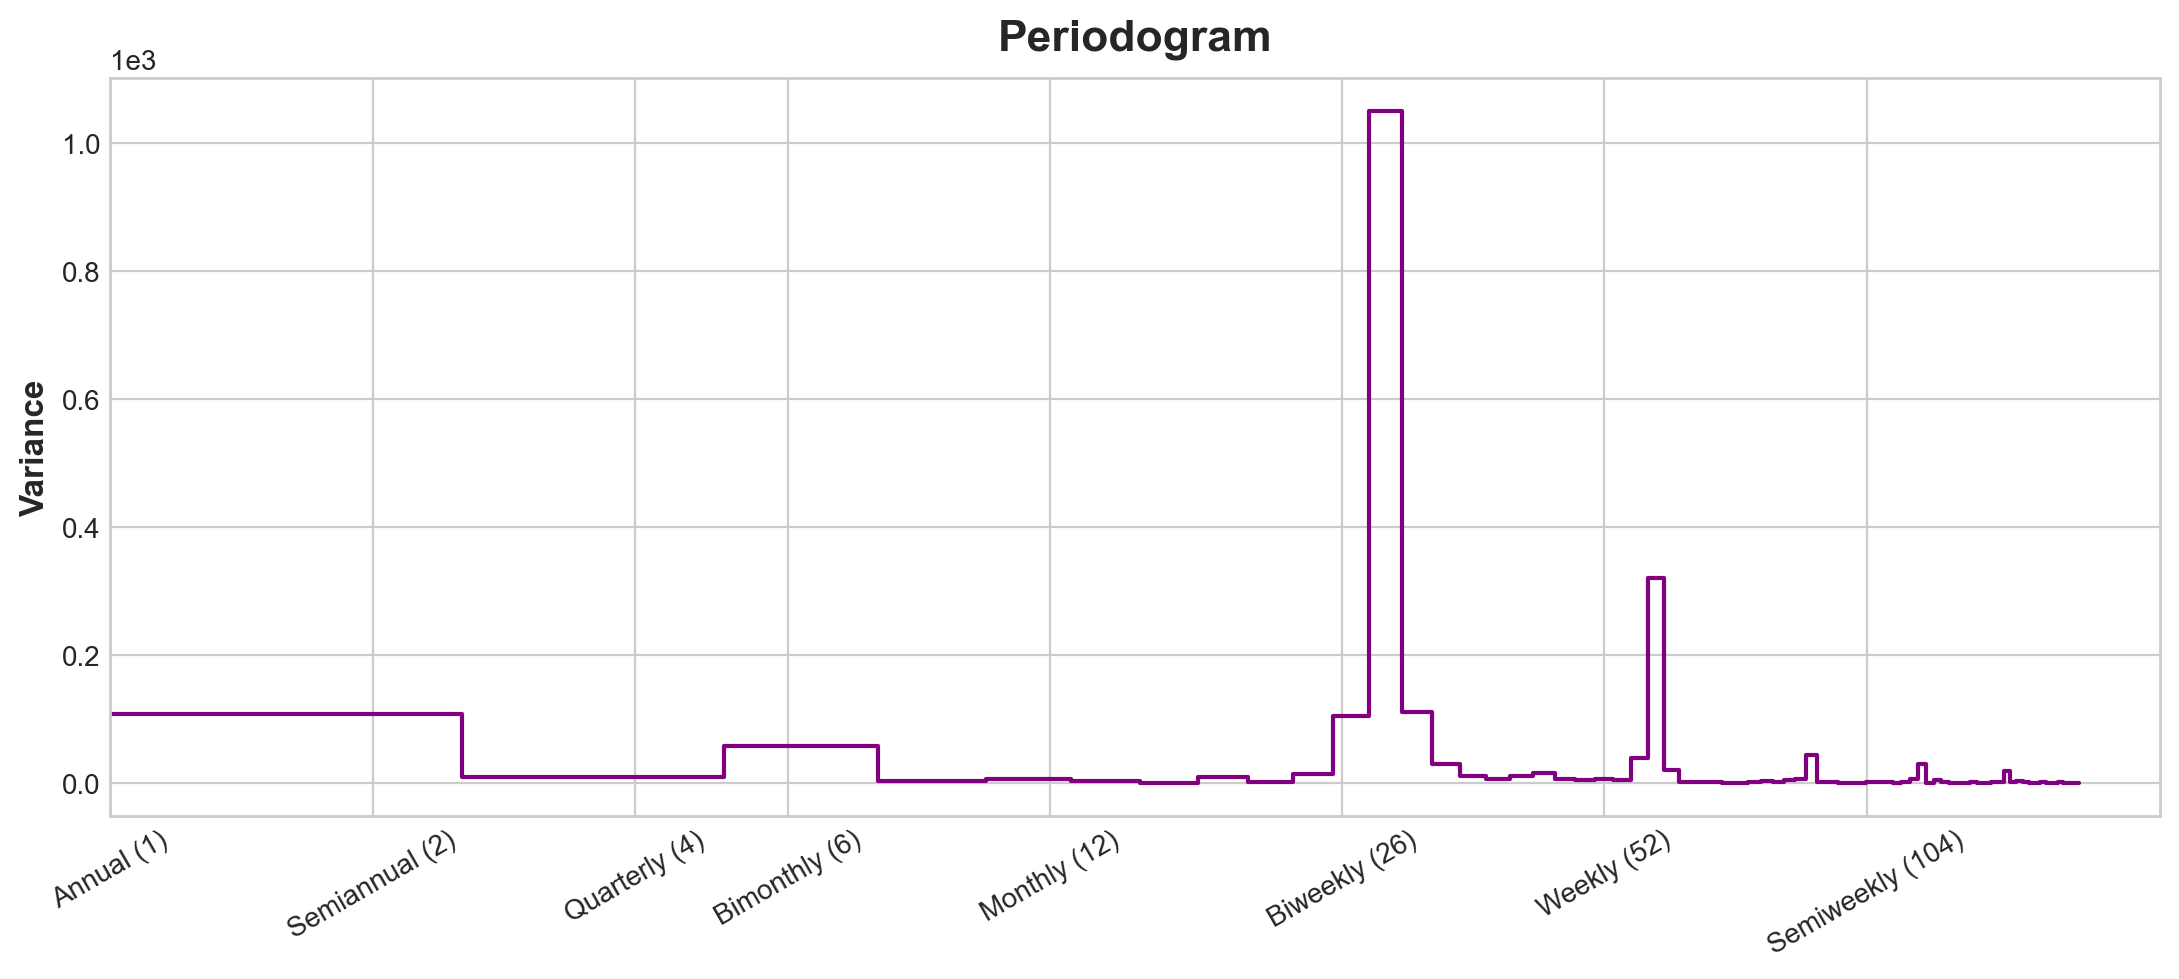

In [7]:
plot_periodogram(df["Passengers"]);

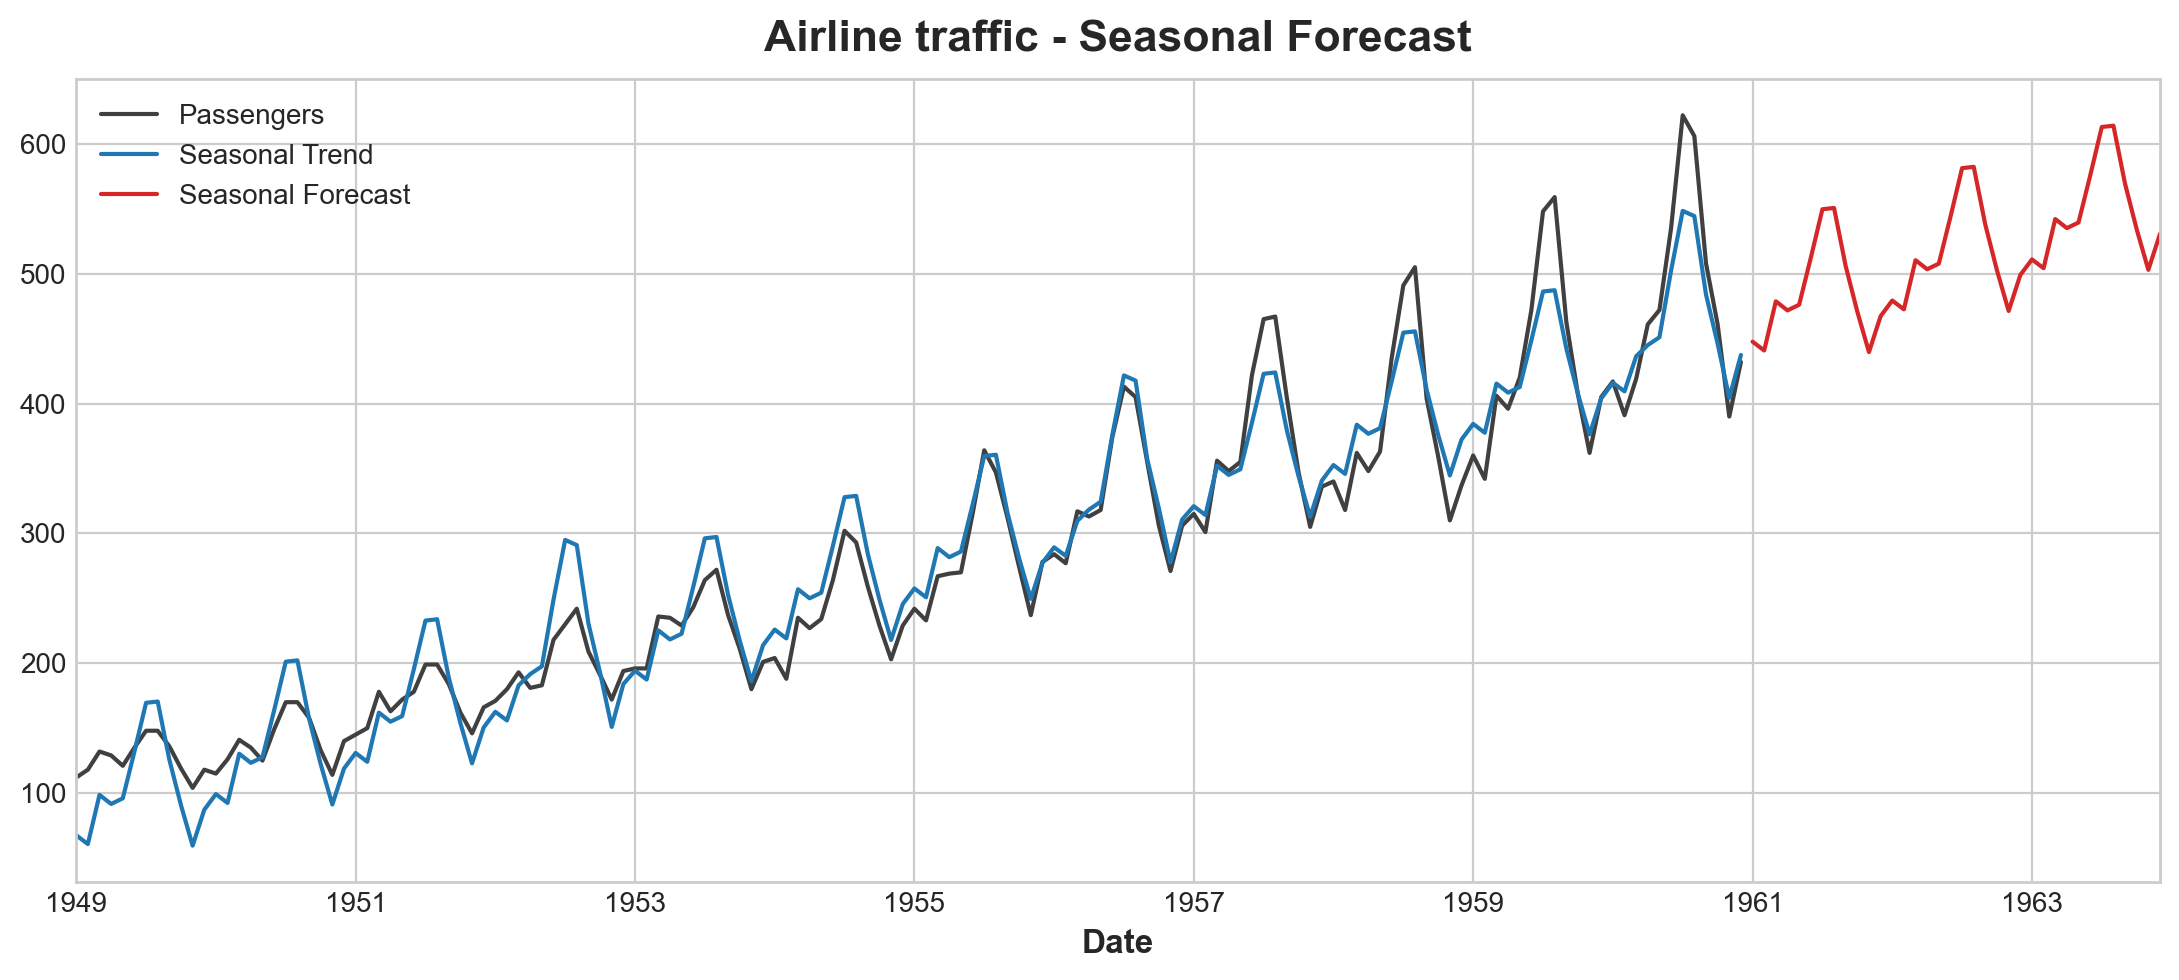

In [8]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="YE", order=10)  # Year end seasonality

dp = DeterministicProcess(
    index=df.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in df.index

y = df["Passengers"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=36)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', title="Airline traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal Trend")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()